# Run on Real Dataset

# imports

In [1]:
import build_graph
import util
import simple_matching_coeffitient
import LaplaceDynamic
import SGL_KB_lpa
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from random import shuffle
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

## Choose data you would like to use
### Data statics are displayed
#### S : adjacency matrix with prepoces
#### S_ori : original adjacency matrix
#### A : attribute matrix with preprocess
#### clus : true cluster of nodes
#### flag : with ground truth or without
#### A_ori : original attribute matrix

In [2]:
# data="WebKB_univ"
# data="citeseer"
# data = "polblog"
data = "cora"
data_path = "../data/"+data
S, S_ori, X, true_clus, flag, A_ori = build_graph.build_graph(data_path)

cite
number of nodes : 2708
number of attributes : 1433
number of edges : 5278


## Convert to NetworkX Graph

### select max connected component


In [3]:
G = nx.Graph(S_ori)
a_dic = {i : A_ori[i] for i in range(0, len(A_ori) ) }
c_dic = {i : n for i , n in enumerate(true_clus )}
orig_lister_dic = {n : [] for  n in set(true_clus )}
for i , n in enumerate(true_clus ):
    orig_lister_dic.setdefault(n, []).append(i) 

nx.set_node_attributes(G, a_dic, 'attr_vec')
nx.set_node_attributes(G, c_dic, 'club')
GMax = max(nx.connected_components(G), key=len)
G = G.subgraph(GMax)
print('number of nodes Max connected Component : ' , len(G.nodes))
print('number of edges Max connected Component : ' , len(G.edges))

number of nodes Max connected Component :  2485
number of edges Max connected Component :  5069


## Calculate Node Similarity

In [9]:
_score = {}
for e in G.edges:
    n_0_v = G.nodes[e[0]]['attr_vec']
    n_1_v = G.nodes[e[1]]['attr_vec']
    # _score.update( {e : {'weight' : simple_matching_coeffitient.SMC(n_0_v , n_1_v)}})
    # _score.update( {e : {'weight' : cosine_similarity([n_0_v] , [n_1_v])}})
    _score.update( {e : {'weight' : jaccard_score(n_0_v , n_1_v)}})
nx.set_edge_attributes(G, _score)

## Calculate Node Laplacian Centrality and applying LPA

In [10]:
nodes_cent = LaplaceDynamic.lap_cent_weighted(G)
dic_lc = {i : np.ceil(nodes_cent[i]) for i in nodes_cent }
nx.set_node_attributes(G, dic_lc, 'weight')
G, communities =SGL_KB_lpa.asyn_lpa_communities(G)

## Evaluation

In [11]:
v_orig, v_pred = util.convertToResultVec(G, communities, orig_lister_dic)
nmi = normalized_mutual_info_score(v_orig , v_pred)
acc = accuracy_score(v_orig , v_pred)
print('NMI -> ', nmi)
print('ACC -> ', acc)

NMI ->  0.3839533070543133
ACC ->  0.2917505030181087


## Graph

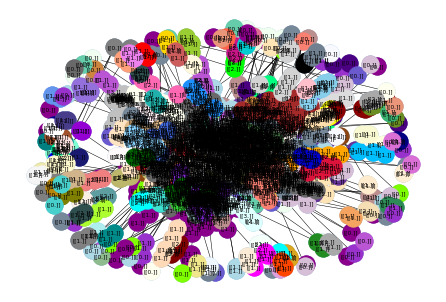

In [8]:
pos = nx.spring_layout(G) #calculate position for each node
nx.draw(G,pos, with_labels=True, labels=nx.get_node_attributes(G,'weight') , font_weight='light', node_size= 280, width= 0.5, font_size= 'xx-small')
color_list = list(mcolors.CSS4_COLORS)
shuffle(color_list)
i=0
for x in communities:
    nx.draw_networkx_nodes(G,pos, nodelist=communities[x], node_color=color_list[i%len(color_list)])
    i+=1
plt.draw()
plt.show()